<a href="https://colab.research.google.com/github/erika-munho/TalentoTech/blob/main/Clustering_Iris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install umap
!pip install umap-learn

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("darkgrid")

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

import umap

from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS


import random
import time

std_figure_size = (8,5)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=14, titlepad=10)

fixed_random_state = random.seed(42)
n_parallel_jobs = -1

%config IPCompleter.use_jedi=False

**Reading in the dataset**

In [ ]:
iris = sns.load_dataset("iris")
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


**Any duplicate rows?**

In [ ]:
n_dup = len(iris) - len(iris.drop_duplicates())

print(f"Number of duplicate rows: {n_dup}")

Number of duplicate rows: 1


**Any missing values?**

In [ ]:
iris.isnull().sum()

sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64

**Checking data types**

In [ ]:
iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [ ]:
# Eliminar la columna categórica 'C' del DataFrame
iris_n = iris.drop(columns=['species'])

iris_n.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
dtypes: float64(4)
memory usage: 4.8 KB


**Cleaning up column names (mainly for handling purposes)**

In [ ]:
cols_cleaned = []

for col in iris_n.columns:
    cols_cleaned.append(col.strip().lower())

iris_n.columns = cols_cleaned

# sanity check
iris_n.head()

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


**Quick overview over the individual distributions**

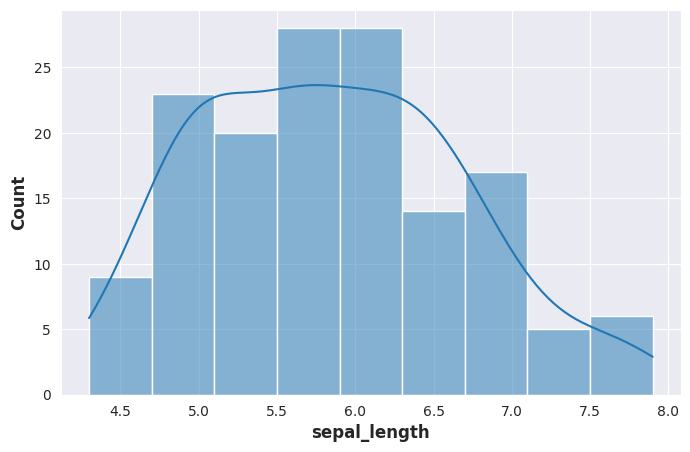

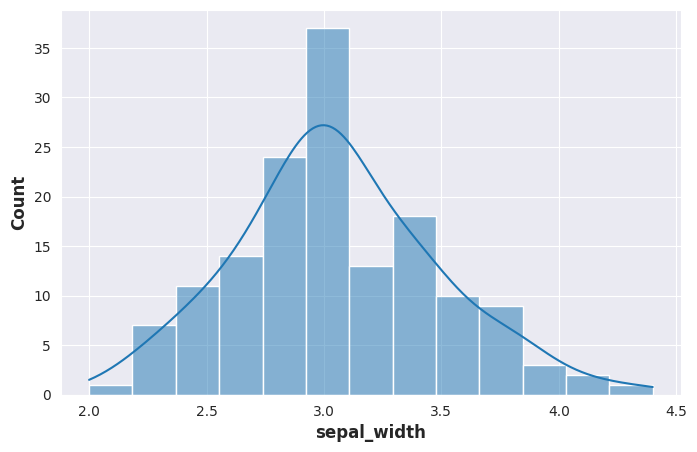

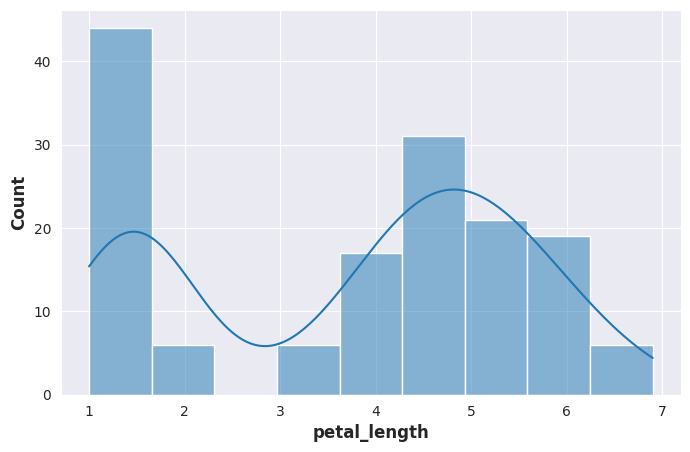

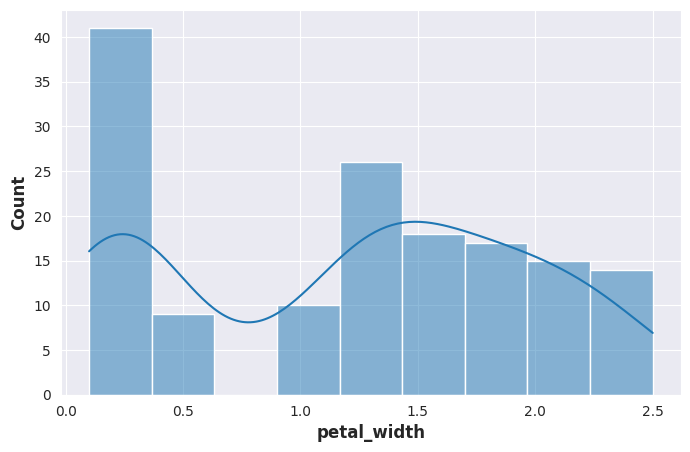

In [ ]:
for col in iris_n.columns:
    fig, axs = plt.subplots(figsize=std_figure_size)
    sns.histplot(data=iris_n, x=col, kde=True, ax=axs)
    plt.show()

# Clustering

In [ ]:
algos = ["K-means", "Mean shift", "Gaussian mixtures", "Affinity propagation", "DBSCAN", "OPTICS"]

# saving training times for each algo
training_times = []

# Scaling and Standardizing

In [ ]:
X = StandardScaler().fit_transform(iris_n)

In [ ]:
X = PowerTransformer(standardize=False).fit_transform(X)

In [ ]:
X = pd.DataFrame(X, columns=iris_n.columns)

# sanity check
X.head()

,sepal_length,sepal_width,petal_length,petal_width
0,-0.972914,0.953811,-1.120641,-1.222596
1,-1.254819,-0.133410,-1.120641,-1.222596
2,-1.543675,0.320242,-1.161675,-1.222596
3,-1.690529,0.097427,-1.079229,-1.222596
4,-1.112958,1.156179,-1.120641,-1.222596


# Dimensionality reduction via UMAP

In [ ]:
reducer = umap.UMAP(n_components=2, n_neighbors=25, n_jobs=n_parallel_jobs, random_state=fixed_random_state)
embedding = reducer.fit_transform(X)

X = pd.DataFrame(embedding, columns=["comp_1", "comp_2"])

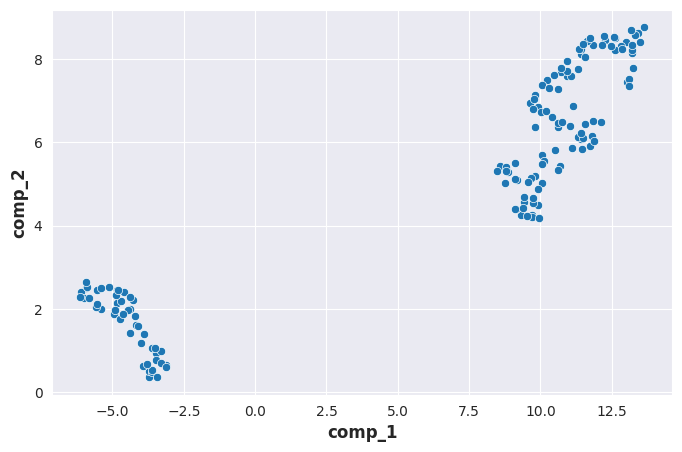

In [ ]:
plt.figure(figsize=std_figure_size)
sns.scatterplot(data= X, x="comp_1", y="comp_2")
plt.show()

# Definition of plotting and convergence check function

In [ ]:
# function to visualize identified clusters

def visualize_clusters(*, df, labels_all, hyperparam_name, hyperparam_val, noise_exist):
    """Visualisation of identified clusters. Only a single hyperparameter is considered.

    Arguments
    =========
    df: pandas.DataFrame
        Dataframe of input features.
    labels_all: list | numpy.array
        Identified cluster IDs.
    hyperparam_name: str | None
        Name of hyperparameter.
    hyperparam_val: float | int | None
        Value of hyperparameter.
    noise_exist: bool
        True if algo models noise, False otherwise.
        Assumes encoding of noise as cluster ID = -1.

    Returns
    =======
    None
    Prints a figure.

    """

    # Checking of input parameters omitted for this notebook

    labels = sorted(pd.Series(labels_all).unique())

    if noise_exist:

        outlier_perc = int(round(( (len(df) - sum(np.where(labels_all == -1, False, True))) / len(df) ) * 100, 0))

        plt.figure(figsize=std_figure_size)
        for label in labels:
            if label == -1:
                marker_style = "*"
            else:
                marker_style = "o"
            sns.scatterplot(data=df.loc[labels_all == label, :], x="comp_1", y="comp_2", label=str(label), marker=marker_style)
        if hyperparam_name or hyperparam_val:
            plt.title(f"{hyperparam_name}: {hyperparam_val}; 'Noise': {outlier_perc}%")
        else:
            plt.title(f"Defaults for all hyperparameters; 'Noise': {outlier_perc}%")
        plt.legend(title="cluster ID")
        plt.show()

    else:

        plt.figure(figsize=std_figure_size)
        for label in labels:
            sns.scatterplot(data=df.loc[labels_all == label, :], x="comp_1", y="comp_2", label=str(label))
        if hyperparam_name or hyperparam_val:
            plt.title(f"{hyperparam_name}: {hyperparam_val}")
        else:
            plt.title(f"Defaults for all hyperparameters")
        plt.legend(title="cluster ID")
        plt.show()


def convergence_check(model):
    """Checking if fitted model converged within the max. number of iterations."""
    if model.n_iter_ < model.max_iter:
        print(f"Algorithm converged successfully!\nn_iter: {model.n_iter_}, max_iter: {model.max_iter}\n")
    else:
        print(f"WARNING: Algorithm did not converge within {model.max_iter} iterations!\n")

# Algo 1: K-means

In [ ]:
# hyperparameter to tune

kmeans_hparam = "n_clusters"

## Identifying the "optimal" number of clusters

In [ ]:
inertias_1 = []
range_clusters_1 = np.arange(2, 10, dtype=int)

for n in range_clusters_1:
    kmeans_1 = KMeans(n_clusters=n, random_state=fixed_random_state).fit(X)
    inertias_1.append(kmeans_1.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

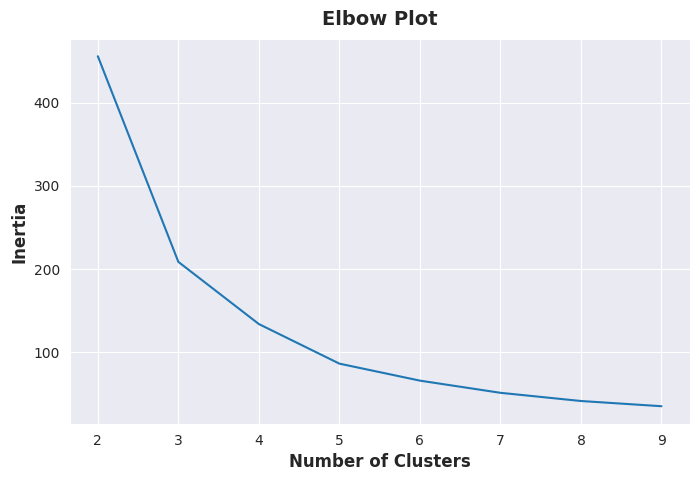

In [ ]:
fig, axs = plt.subplots(figsize=std_figure_size)
sns.lineplot(x=range_clusters_1, y=inertias_1)
plt.title('Elbow Plot')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

## Run with optimised n_clusters

In [ ]:
%%time

start_time = time.time()

kmeans = KMeans(n_clusters=3, random_state=fixed_random_state)

labels_1 = kmeans.fit_predict(X)

convergence_check(kmeans)

training_times.append(time.time() - start_time)

Algorithm converged successfully!
n_iter: 2, max_iter: 300

CPU times: user 62.9 ms, sys: 0 ns, total: 62.9 ms
Wall time: 62.2 ms


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


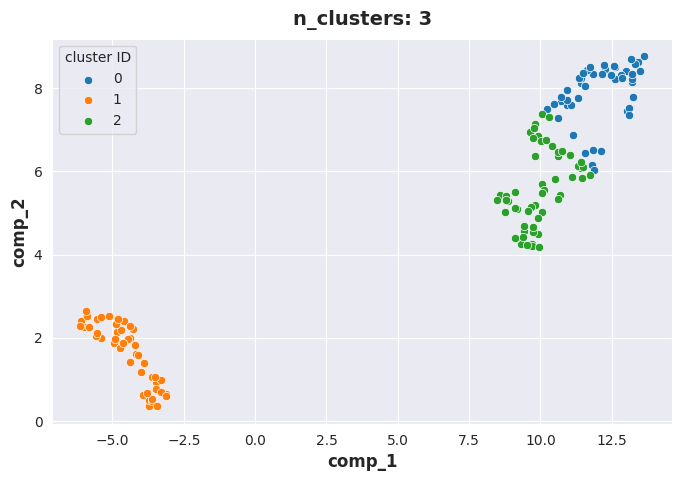

In [ ]:
visualize_clusters(df=X, labels_all=labels_1, hyperparam_name=kmeans_hparam, hyperparam_val=3, noise_exist=False)

# Algo 2: Mean shift

In [ ]:
# hyperparamter to tune

meanshift_hparam = "bandwidth"

## Vanilla run (defaults for all hyperparameters)

In [ ]:
%%time

start_time = time.time()

meanshift = MeanShift(n_jobs=n_parallel_jobs)

labels_2 = meanshift.fit_predict(X)

convergence_check(meanshift)

training_times.append(time.time() - start_time)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Algorithm converged successfully!
n_iter: 10, max_iter: 300

CPU times: user 295 ms, sys: 140 ms, total: 435 ms
Wall time: 3.63 s


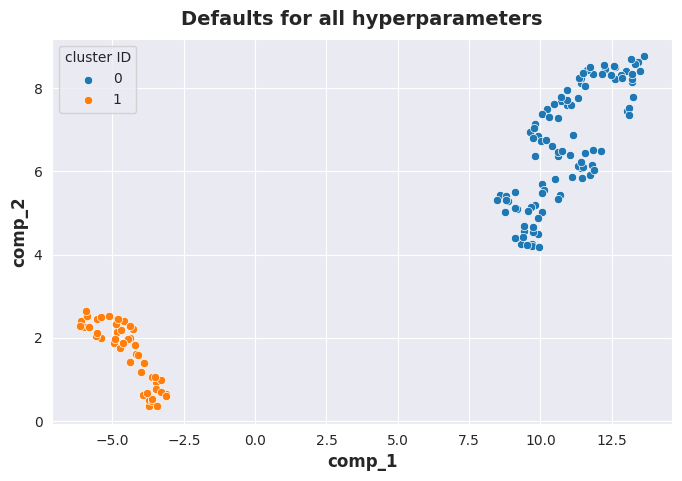

In [ ]:
visualize_clusters(df=X, labels_all=labels_2, hyperparam_name=None, hyperparam_val=None, noise_exist=False)

## Allowing for 'noise'

In [ ]:
%%time

start_time = time.time()

meanshift = MeanShift(cluster_all=False, n_jobs=n_parallel_jobs)

labels_2 = meanshift.fit_predict(X)

convergence_check(meanshift)

training_time_meanshift_noise = time.time() - start_time

Algorithm converged successfully!
n_iter: 10, max_iter: 300

CPU times: user 312 ms, sys: 7.4 ms, total: 319 ms
Wall time: 1.12 s


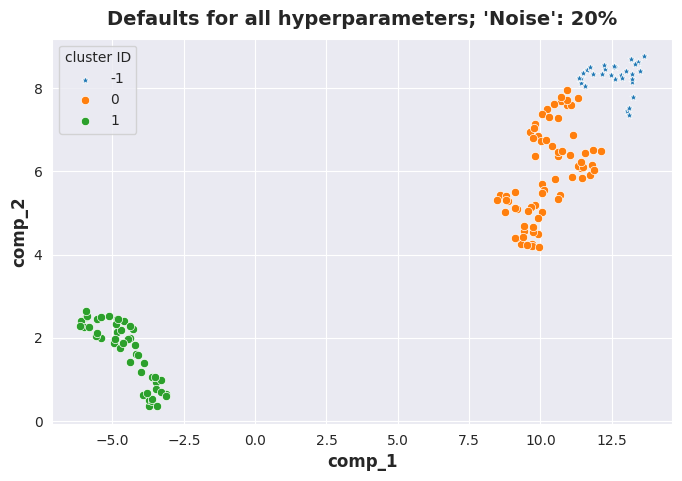

In [ ]:
visualize_clusters(df=X, labels_all=labels_2, hyperparam_name=None, hyperparam_val=None, noise_exist=True)

# Algo 3: Gaussian Mixture

In [ ]:
# hyperparamter to tune

gmm_hparam = "n_components"

In [ ]:
%%time

start_time = time.time()

gmm = GaussianMixture(n_components=3, random_state=fixed_random_state)

labels_3 = gmm.fit_predict(X)

convergence_check(gmm)

training_times.append(time.time() - start_time)

Algorithm converged successfully!
n_iter: 12, max_iter: 100

CPU times: user 53 ms, sys: 34.7 ms, total: 87.7 ms
Wall time: 106 ms


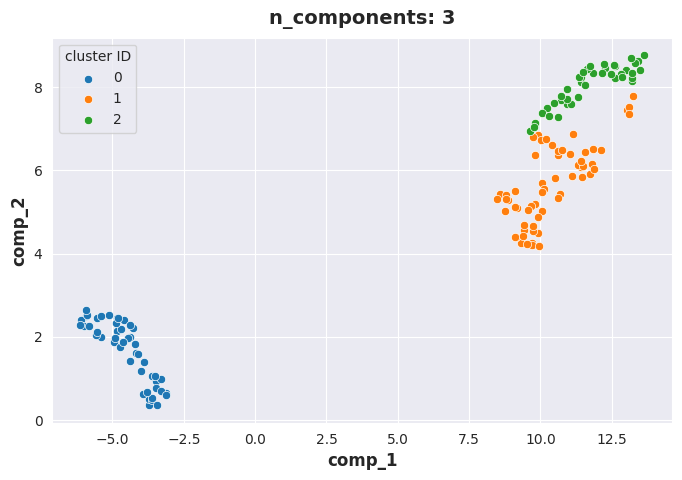

In [ ]:
visualize_clusters(df=X, labels_all=labels_3, hyperparam_name=gmm_hparam, hyperparam_val=3, noise_exist=False)

# Algo 4: Affinity propagation

In [ ]:
# hyperparamter to tune

affprop_hparam = "damping"

## Vanilla run (defaults for all hyperparameters)

In [ ]:
%%time

affprop = AffinityPropagation(random_state=fixed_random_state)

labels_4 = affprop.fit_predict(X)

convergence_check(affprop)

Algorithm converged successfully!
n_iter: 29, max_iter: 200

CPU times: user 28.2 ms, sys: 805 µs, total: 29 ms
Wall time: 85 ms


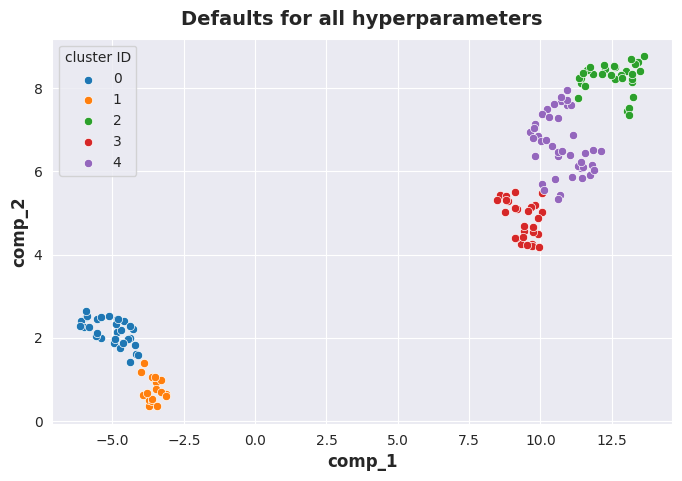

In [ ]:
visualize_clusters(df=X, labels_all=labels_4, hyperparam_name=None, hyperparam_val=None, noise_exist=False)

## Tuning runs for "damping"

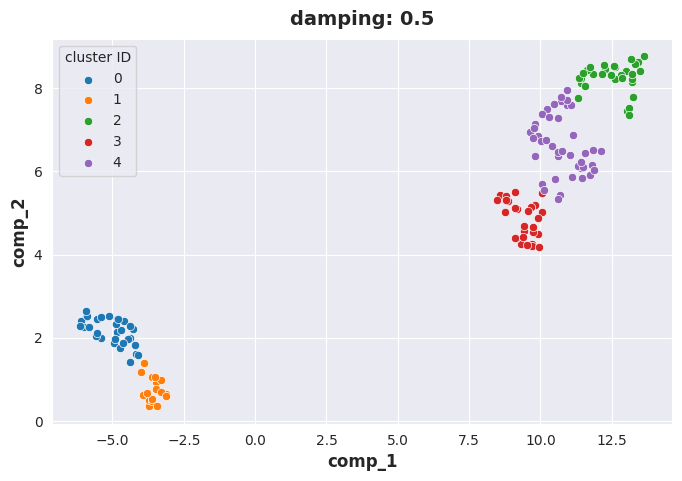

Algorithm converged successfully!
n_iter: 29, max_iter: 500



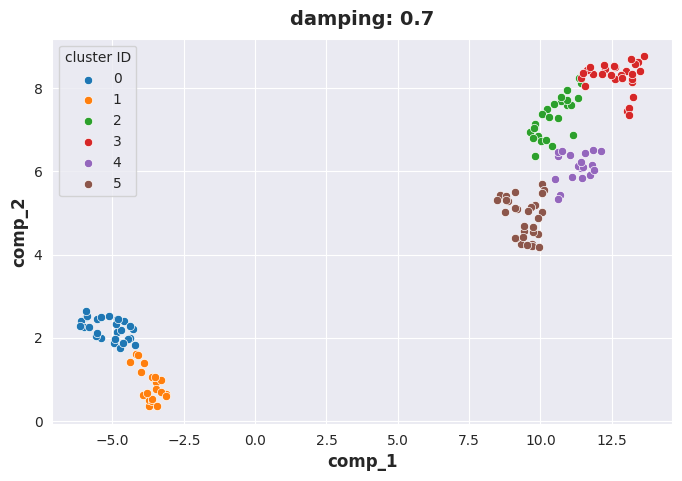

Algorithm converged successfully!
n_iter: 28, max_iter: 500



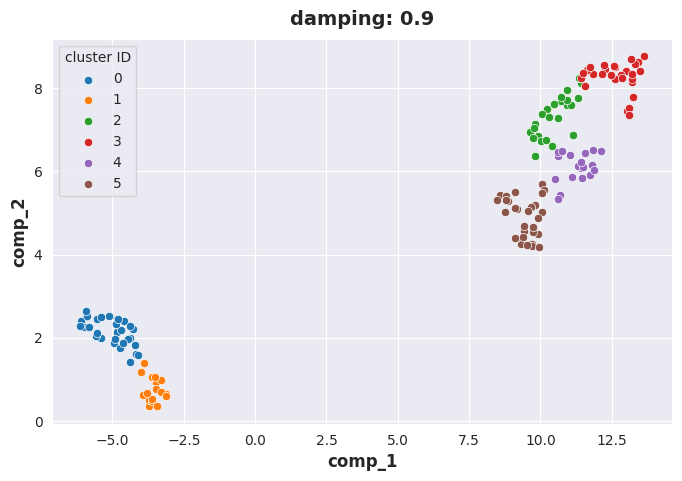

Algorithm converged successfully!
n_iter: 51, max_iter: 500



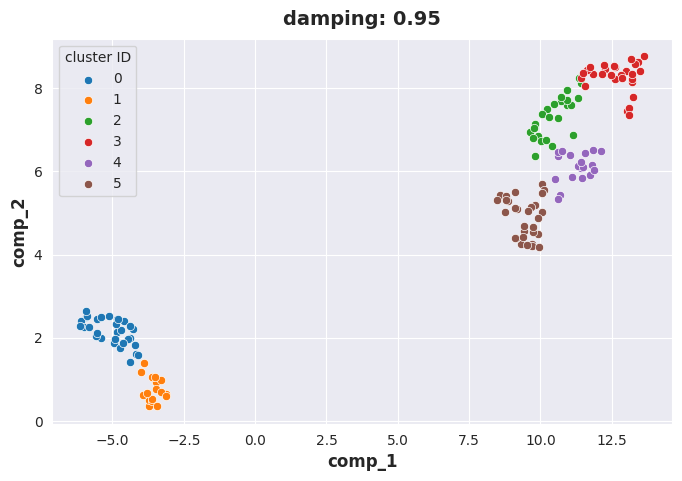

Algorithm converged successfully!
n_iter: 89, max_iter: 500



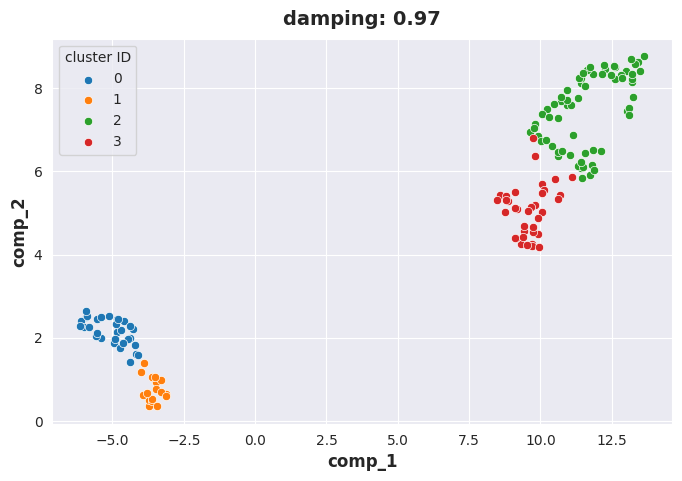

Algorithm converged successfully!
n_iter: 118, max_iter: 500



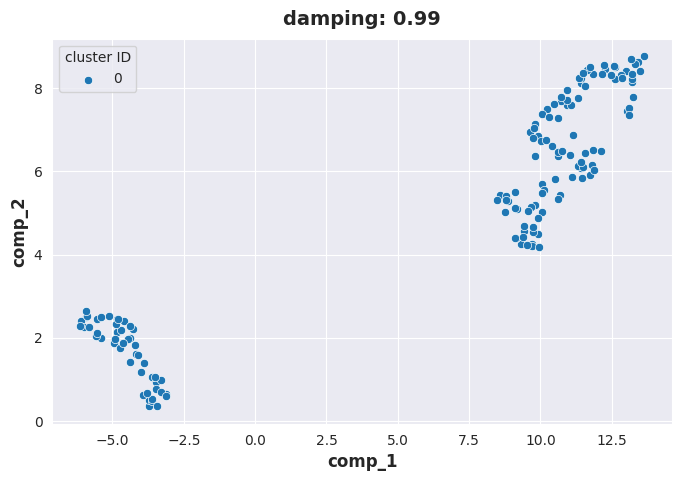

Algorithm converged successfully!
n_iter: 298, max_iter: 500

CPU times: user 5.66 s, sys: 244 ms, total: 5.91 s
Wall time: 8.64 s


In [ ]:
%%time

damps = [0.5, 0.7, 0.9, 0.95, 0.97, 0.99]

for d in damps:
    affprop = AffinityPropagation(damping=d, max_iter=500, random_state=fixed_random_state)
    labels_4 = affprop.fit_predict(X)
    visualize_clusters(df=X, labels_all=labels_4, hyperparam_name=affprop_hparam, hyperparam_val=d, noise_exist=False)
    convergence_check(affprop)

## Tuning runs for "preference"

In [ ]:
# hyperparamter to tune

affprop_hparam = "preference"

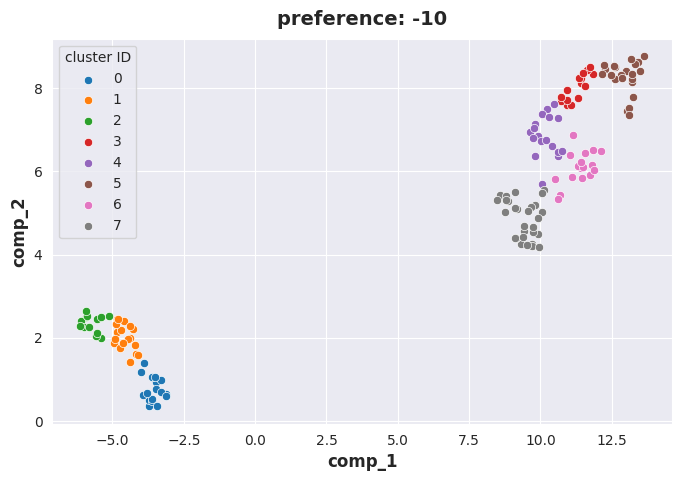

Algorithm converged successfully!
n_iter: 32, max_iter: 500



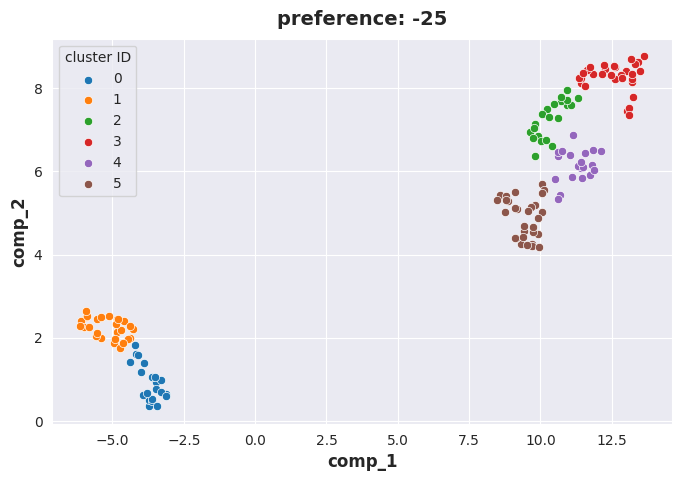

Algorithm converged successfully!
n_iter: 36, max_iter: 500



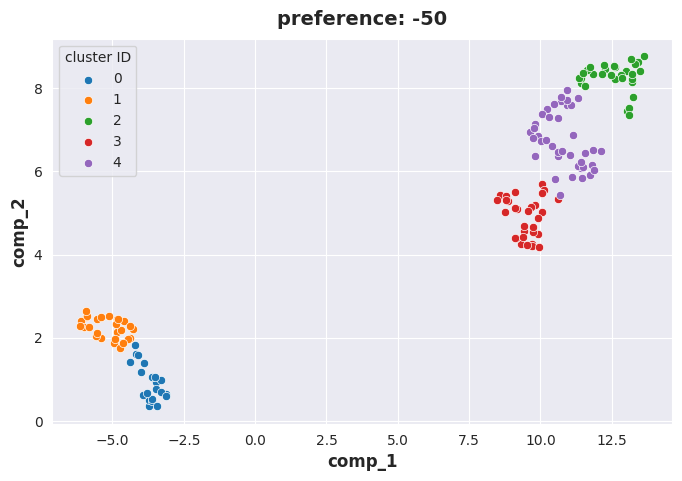

Algorithm converged successfully!
n_iter: 76, max_iter: 500



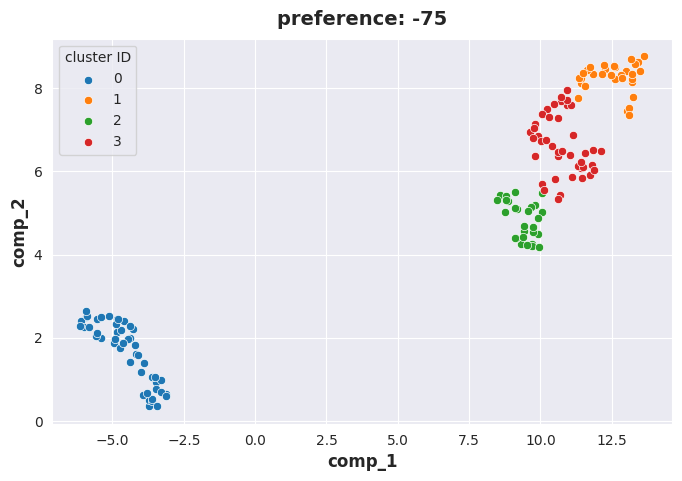

Algorithm converged successfully!
n_iter: 81, max_iter: 500



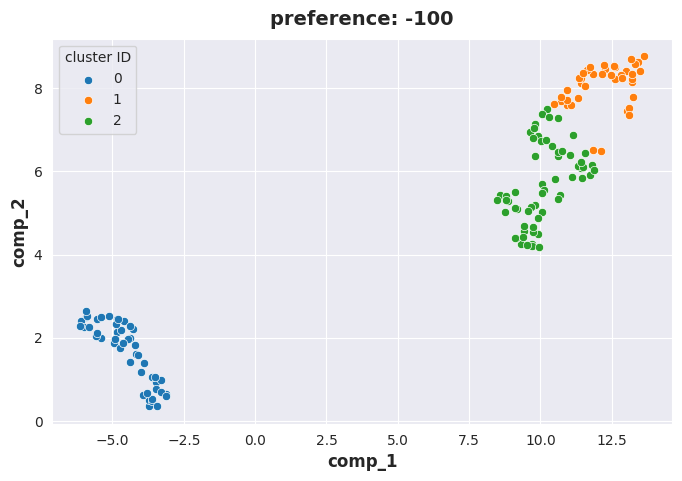

Algorithm converged successfully!
n_iter: 166, max_iter: 500

CPU times: user 4.93 s, sys: 165 ms, total: 5.1 s
Wall time: 9.28 s


In [ ]:
%%time

prefs = [-10, -25, -50, -75, -100]

for p in prefs:
    affprop = AffinityPropagation(preference=p, max_iter=500, random_state=fixed_random_state)
    labels_4 = affprop.fit_predict(X)
    visualize_clusters(df=X, labels_all=labels_4, hyperparam_name=affprop_hparam, hyperparam_val=p, noise_exist=False)
    convergence_check(affprop)

## Re-run with optimised preference

In [ ]:
%%time

start_time = time.time()

affprop = AffinityPropagation(preference=-75, max_iter=500, random_state=fixed_random_state)

labels_4 = affprop.fit_predict(X)

convergence_check(affprop)

training_times.append(time.time() - start_time)

Algorithm converged successfully!
n_iter: 80, max_iter: 500

CPU times: user 62.9 ms, sys: 0 ns, total: 62.9 ms
Wall time: 106 ms


# Algo 5: DBSCAN

In [ ]:
# hyperparamter to tune

dbscan_hparam = "eps"

## Vanilla run (defaults for all hyperparameters)

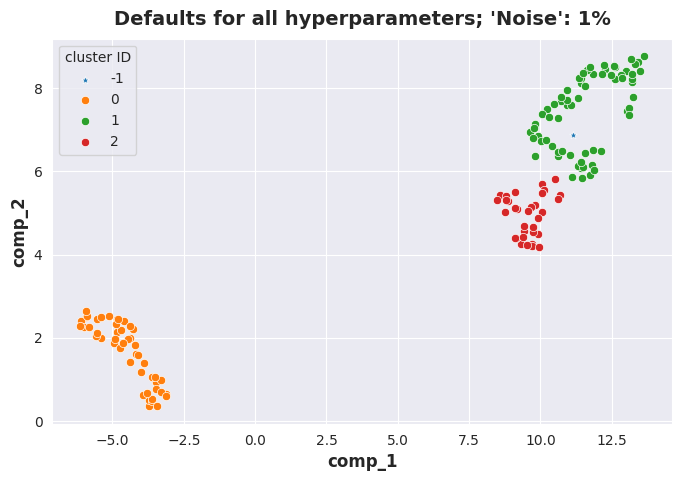

CPU times: user 878 ms, sys: 54.5 ms, total: 932 ms
Wall time: 1.86 s


In [ ]:
%%time

dbscan = DBSCAN(n_jobs=n_parallel_jobs)

labels_5 = dbscan.fit_predict(X)

visualize_clusters(df=X, labels_all=labels_5, hyperparam_name=None, hyperparam_val=None, noise_exist=True)

## Tuning runs for eps

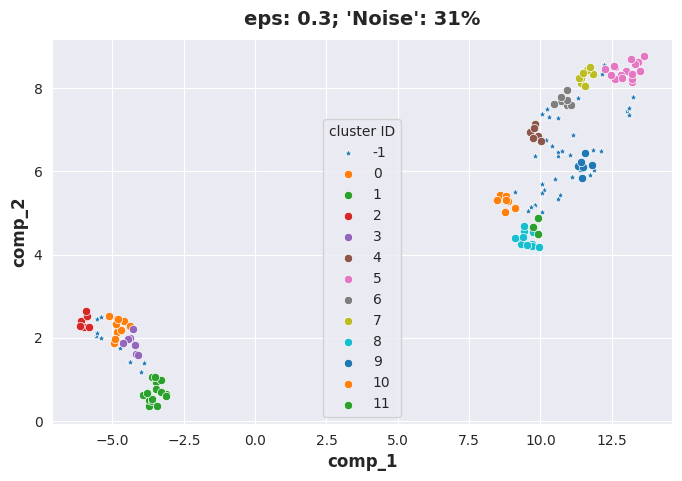

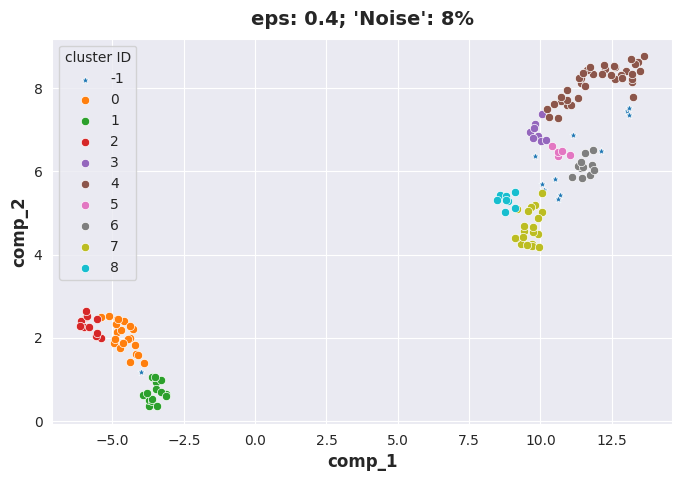

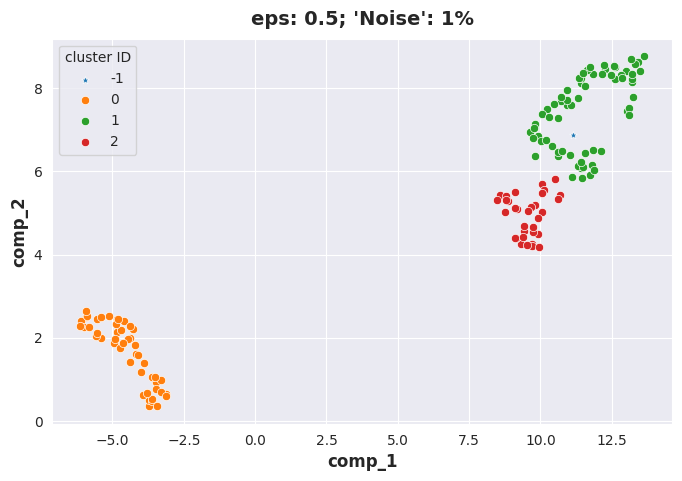

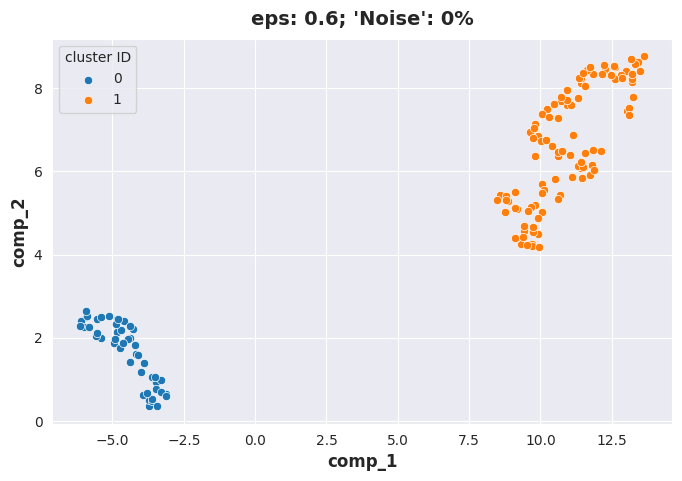

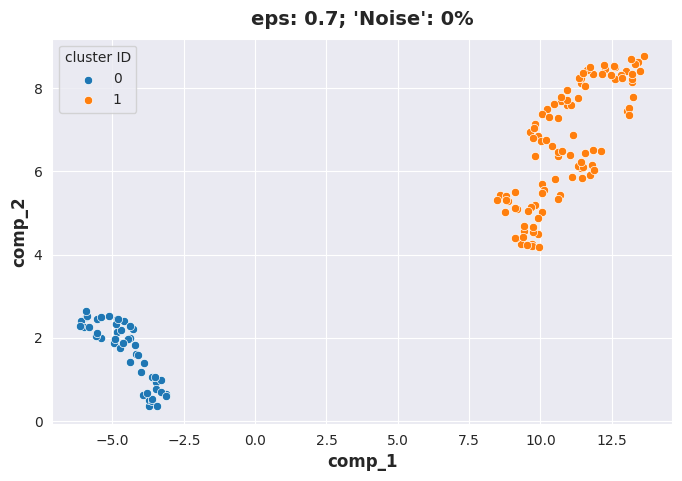

CPU times: user 6 s, sys: 247 ms, total: 6.25 s
Wall time: 10.8 s


In [ ]:
%%time

for e in [0.3, 0.4, 0.5, 0.6, 0.7]:

    dbscan = DBSCAN(eps=e, n_jobs=n_parallel_jobs)
    labels_5 = dbscan.fit_predict(X)

    visualize_clusters(df=X, labels_all=labels_5, hyperparam_name=dbscan_hparam, hyperparam_val=e, noise_exist=True)

## Re-run with optimised eps

In [ ]:
%%time

eps_val = 0.6

start_time = time.time()

dbscan = DBSCAN(eps=eps_val, n_jobs=n_parallel_jobs)

labels_5 = dbscan.fit_predict(X)

training_times.append(time.time() - start_time)

CPU times: user 14.4 ms, sys: 3.97 ms, total: 18.4 ms
Wall time: 96.2 ms


# Algo 6: OPTICS

In [ ]:
# hyperparamter to tune

optics_hparam = "min_samples"

## Vanilla run (defaults for all hyperparameters)

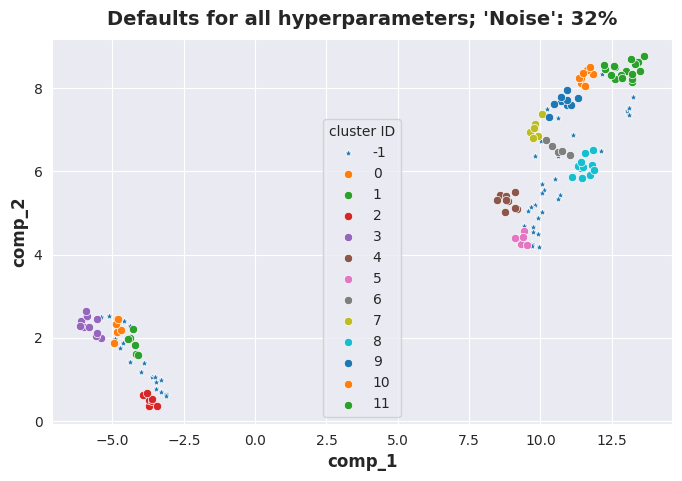

CPU times: user 1.58 s, sys: 280 ms, total: 1.86 s
Wall time: 3.84 s


In [ ]:
%%time

optics = OPTICS(n_jobs=n_parallel_jobs)

labels_6 = optics.fit_predict(X)

visualize_clusters(df=X, labels_all=labels_6, hyperparam_name=None, hyperparam_val=None, noise_exist=True)

## Tuning runs for min_samples

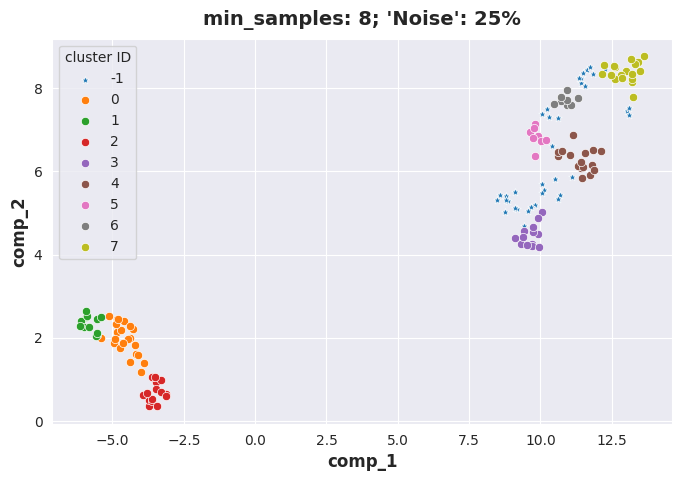

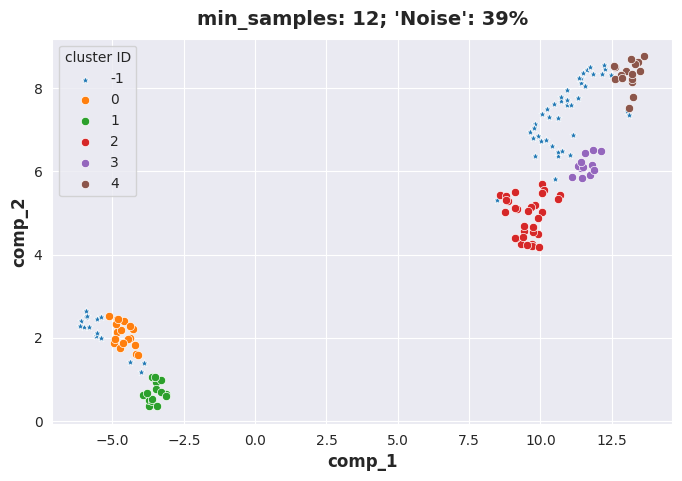

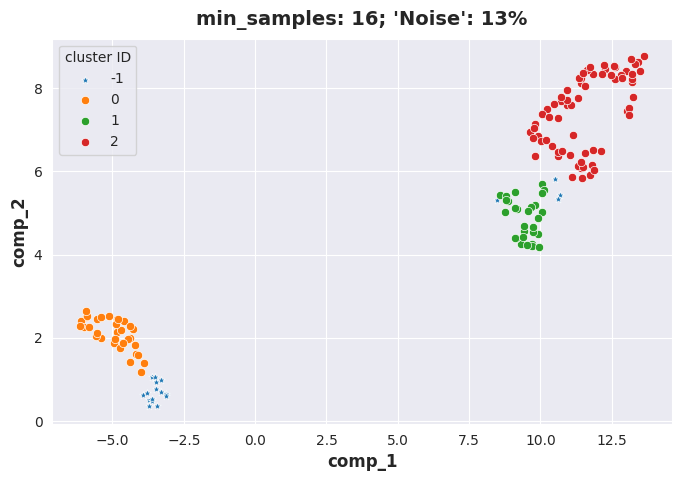

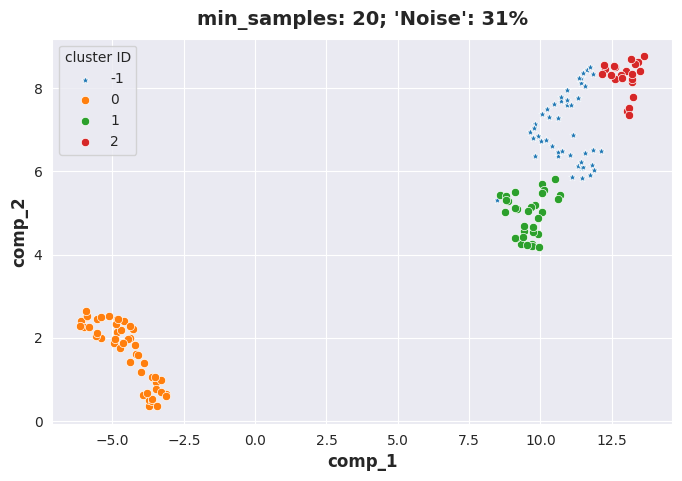

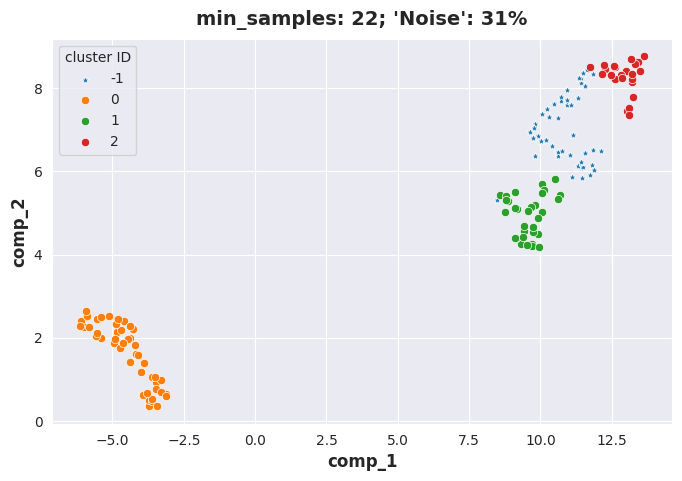

CPU times: user 5.94 s, sys: 1.26 s, total: 7.2 s
Wall time: 13.8 s


In [ ]:
%%time

for n_samples in [8, 12, 16, 20, 22]:

    optics = OPTICS(min_samples=n_samples, n_jobs=n_parallel_jobs)

    labels_6 = optics.fit_predict(X)

    visualize_clusters(df=X, labels_all=labels_6, hyperparam_name=optics_hparam, hyperparam_val=n_samples, noise_exist=True)

## Re-run with optimised min_samples

In [ ]:
%%time

n_samples = 20

start_time = time.time()

optics = OPTICS(min_samples=n_samples, n_jobs=n_parallel_jobs)

labels_6 = optics.fit_predict(X)

training_times.append(time.time() - start_time)

CPU times: user 608 ms, sys: 150 ms, total: 758 ms
Wall time: 2.2 s


# Comparison of training times

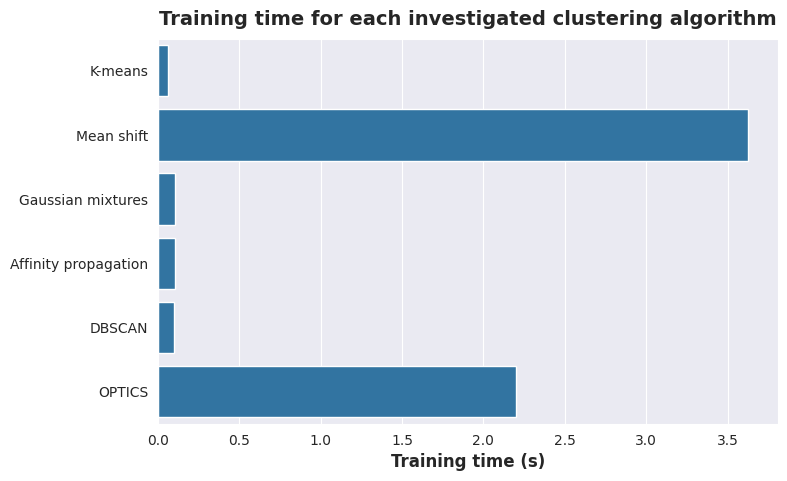

In [ ]:
plt.figure(figsize=std_figure_size)
#sns.barplot(y=algos, x=training_times)
sns.barplot(y=algos, x=training_times)
plt.title("Training time for each investigated clustering algorithm")
plt.xlabel("Training time (s)")
plt.show()

In [ ]:
# overwriting the training time for Mean shift

training_times[1] = training_time_meanshift_noise

In [ ]:
print(algos)
print(training_times)

['K-means', 'Mean shift', 'Gaussian mixtures', 'Affinity propagation', 'DBSCAN', 'OPTICS']
[0.0621945858001709, 1.1242642402648926, 0.1062929630279541, 0.10637235641479492, 0.09620022773742676, 2.2000744342803955]


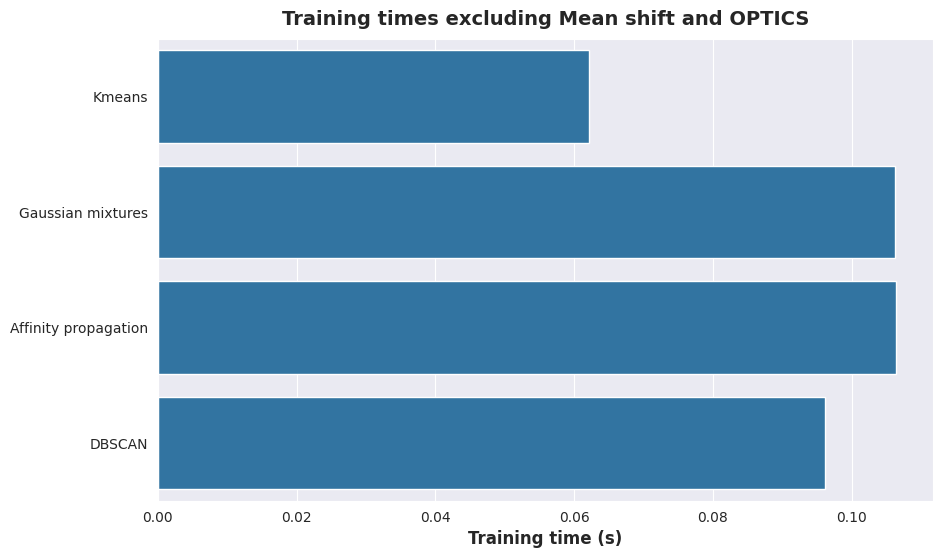

In [ ]:
# Lista de algoritmos de clustering (elimina 'Affinity Propagation' de esta lista)
algos = ['Kmeans', 'Gaussian mixtures', 'Affinity propagation', 'DBSCAN']

# Tiempos de entrenamiento (asegúrate de que los tiempos coincidan con los algoritmos después de eliminar 'Affinity Propagation')
training_times = [0.0621945858001709, 0.1062929630279541, 0.10637235641479492, 0.09620022773742676]

plt.figure(figsize=(10, 6))
sns.barplot(y=algos, x=training_times)
plt.title("Training times excluding Mean shift and OPTICS")
plt.xlabel("Training time (s)")
plt.show()

In [ ]:
#plt.figure(figsize=std_figure_size)
#sns.barplot(y=algos[:-1], x=training_times[:-1])
#plt.title("Training times excluding OPTICS")
#plt.xlabel("Training time (s)")
#plt.show()

## **Conclusions**



*   Aplicando el modelo de clustering para el dataset de Iris se obtienen 3 conglomerados, agrupando las cuatro variables de evaluacion en dos componentes de analisis
*   Los tiempos de entrenamiento de los algoritmos investigados varían considerablemente. En la escala de los tiempos de entrenamiento de los algoritmos Mean shift y OPTICS, los tiempos de entrenamiento de los demás algoritmos prácticamente desaparecen.

*   Al excluir Mean shift y OPTICS de la grafica para comparar los tiempos de entrenamiento de los demás algoritmos en una escala más razonable, se puede concluir que el  algoritmo K-means presenta el tiempo de entrenamiento mas bajo, al rededor de los 0.06 segundos





